# Pancreas 14.5 -> 15.5 PMM

In [1]:
from moscot.problems.time import TemporalNeuralProblem
from moscot.datasets import simulate_data

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scanpy as sc

from ott.tools.sinkhorn_divergence import sinkhorn_divergence
from ott.geometry.pointcloud import PointCloud

In [2]:
adata = sc.read("../Neural-OT/neural_ot/data/pancreas/1415_growth_rate.h5ad")
map_dict = {"14.5": 14.5, "15.5": 15.5}
adata.obs["day"] = adata.obs["day"].copy().map(map_dict)
adata

AnnData object with n_obs × n_vars = 20519 × 16206
    obs: 'day', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'proliferation', 'G2M_score', 'S_score', 'clusters_fig3_final', 'clusters_fig3_final_noep', 'clusters_fig4_final', 'clusters_fig2_final', 'clusters_fig6_broad_final', 'clusters_fig6_fine_final', 'clusters_fig6_alpha_final', 'celltype'
    var: 'n_cells', 'highly_variable_genes', 'expression_mean', 'dispersion', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_fig6_fine_final_colors', 'day_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [3]:
tnp = TemporalNeuralProblem(adata)
tnp = tnp.prepare(time_key="day", joint_attr="X_pca")

In [4]:
tnp = tnp.solve(
        iterations=25000,
        batch_size=1024,
        valid_freq=250,
        log_freq=10,
        patience=100,
        pretrain=True,
        train_size=1.0)

INFO     Solving problem BirthDeathNeuralProblem[stage='prepared', shape=(9633, 10886)].     


  0%|          | 0/25000 [00:00<?, ?it/s]

In [5]:
solution = tnp[14.5, 15.5].solution
solution

NeuralOutput[predicted_cost=245.612, best_loss=97.228, sink_dist=239.588]

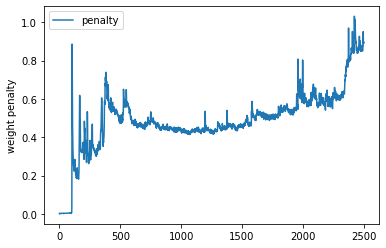

In [6]:
fig, ax = plt.subplots()
ax.plot(solution._training_logs["train_logs"]["penalty"], label="penalty")
ax.set_ylabel("weight penalty")
ax.legend()
plt.show()

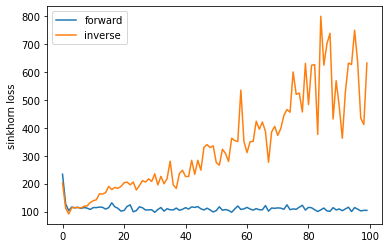

In [7]:
fig, ax = plt.subplots()
ax.plot(solution._training_logs["valid_logs"]["sinkhorn_loss_forward"], label="forward")
ax.plot(solution._training_logs["valid_logs"]["sinkhorn_loss_inverse"], label="inverse")
ax.set_ylabel("sinkhorn loss")
ax.legend()
plt.show()

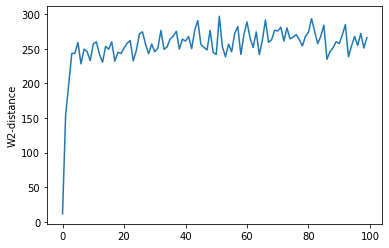

In [8]:
fig, ax = plt.subplots()
ax.plot(solution._training_logs["valid_logs"]["valid_w_dist"])
ax.set_ylabel("W2-distance")
plt.show()

# Cellrank

In [9]:
import cellrank as cr
import scvelo as scv
from tueplots import bundles
from tueplots import axes
scv.set_figure_params('scvelo', transparent=True, fontsize=20)
plt.rcParams.update(**bundles.neurips2022(usetex=False, nrows=2), **axes.lines(base_width=0.5), **{"figure.dpi": 250})

In [10]:
# Prepare for Cellrank
source = jnp.array(adata.obsm["X_pca"].copy())
adata.obs["clusters"] = adata.obs["celltype"]
adata = adata[:, :50].copy()
adata.layers["velocity"] = solution.push(source) - source
adata.layers["velocity"] = np.asarray(adata.layers["velocity"])
adata.layers["pca"] = adata.obsm["X_pca"].copy()

# Velocity Stream Embedding

In [11]:
vk = cr.kernels.VelocityKernel(adata, xkey="pca")
vk.compute_transition_matrix()
adata.uns["velocity_graph"] = vk.transition_matrix

  0%|          | 0/20519 [00:00<?, ?cell/s]

  0%|          | 0/20519 [00:00<?, ?cell/s]

computing velocity embedding
    finished (0:00:03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


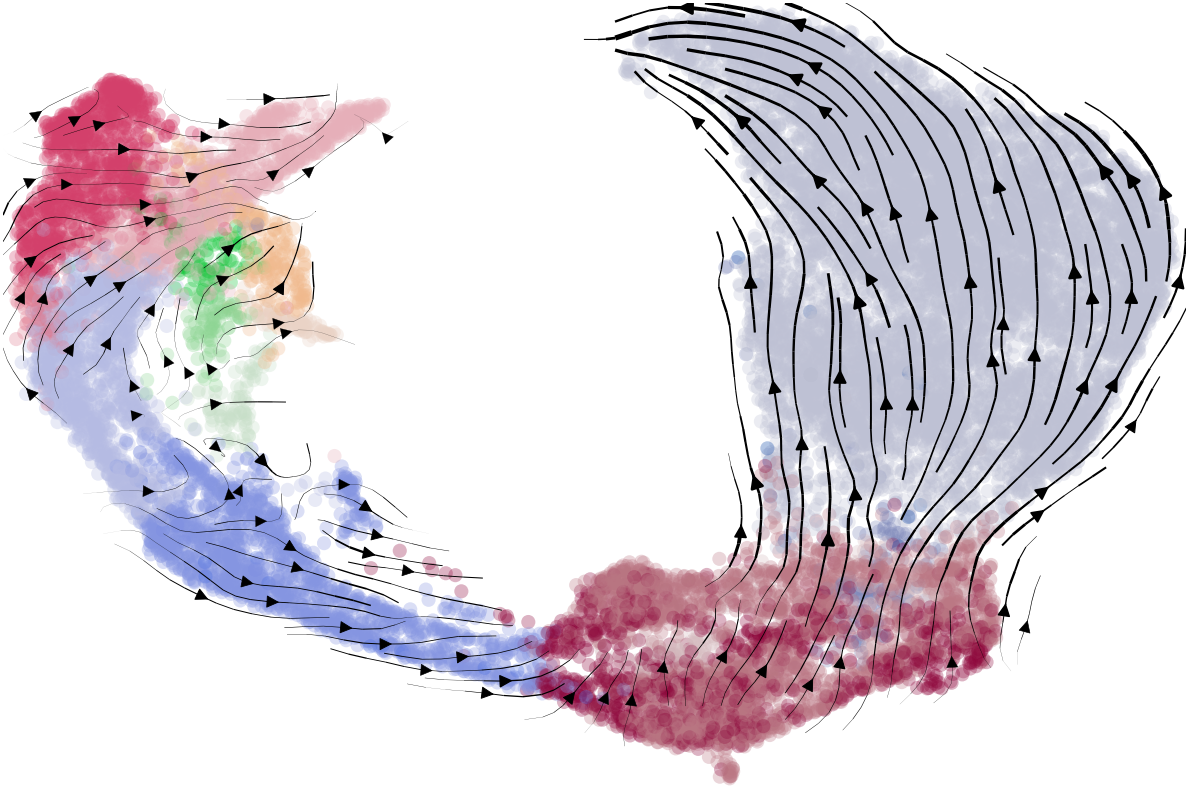

In [12]:
scv.set_figure_params('scvelo', transparent=True, fontsize=20)
scv.pl.velocity_embedding_stream(adata, basis="umap", color="celltype", title="", smooth=0.5, legend_loc='none')

# Macro/Terminalstate computation

In [13]:
g = cr.estimators.GPCCA(vk)
g.compute_schur(n_components=20)

Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000113e+00 -6.4152065375571715e-05 8.2431818715473690e-04 -6.8208705912086356e-03 7.2378661417072171e-03 -2.3459152942176590e-03 -6.2039990658712815e-03 4.2288984699979746e-03 1.4326621753287791e-02 -1.9778991158640871e-02 1.0343229688304969e-02 -1.1682444921905292e-02 1.4117555530482526e-02 9.3364739067844614e-03 3.2677855990221862e-02 3.9836338149385293e-03 -4.9578612935150985e-02 -2.3120090844842831e-02 -6.5438448144205111e-03 2.9754675616149369e-02 
0.0000000000000000e+00 9.9981059840766107e-01 5.6431614150764982e-04 1.3379643719184625e-03 2.7886144728866869e-03 -4.5110502784972983e-04 9.5149657854534002e-04 -2.0983692982045718e-03 -1.7086249657698607e-03 -2.6686725955299605e-02 1.3973573485001372e-02 -4.8973283647867537e-02 -1.1999945139759773e-02 8.1877897679711320e-03 2.2420398040419532e-03 -5.2625894716585601e-03 1.3534251843226108e-02 6.5932238179903331e-03 -1.3552483888020743e-02 -2.5843369763359995e-02 
0.0000000000000

In [28]:
g.compute_macrostates(n_states=20, cluster_key="celltype")

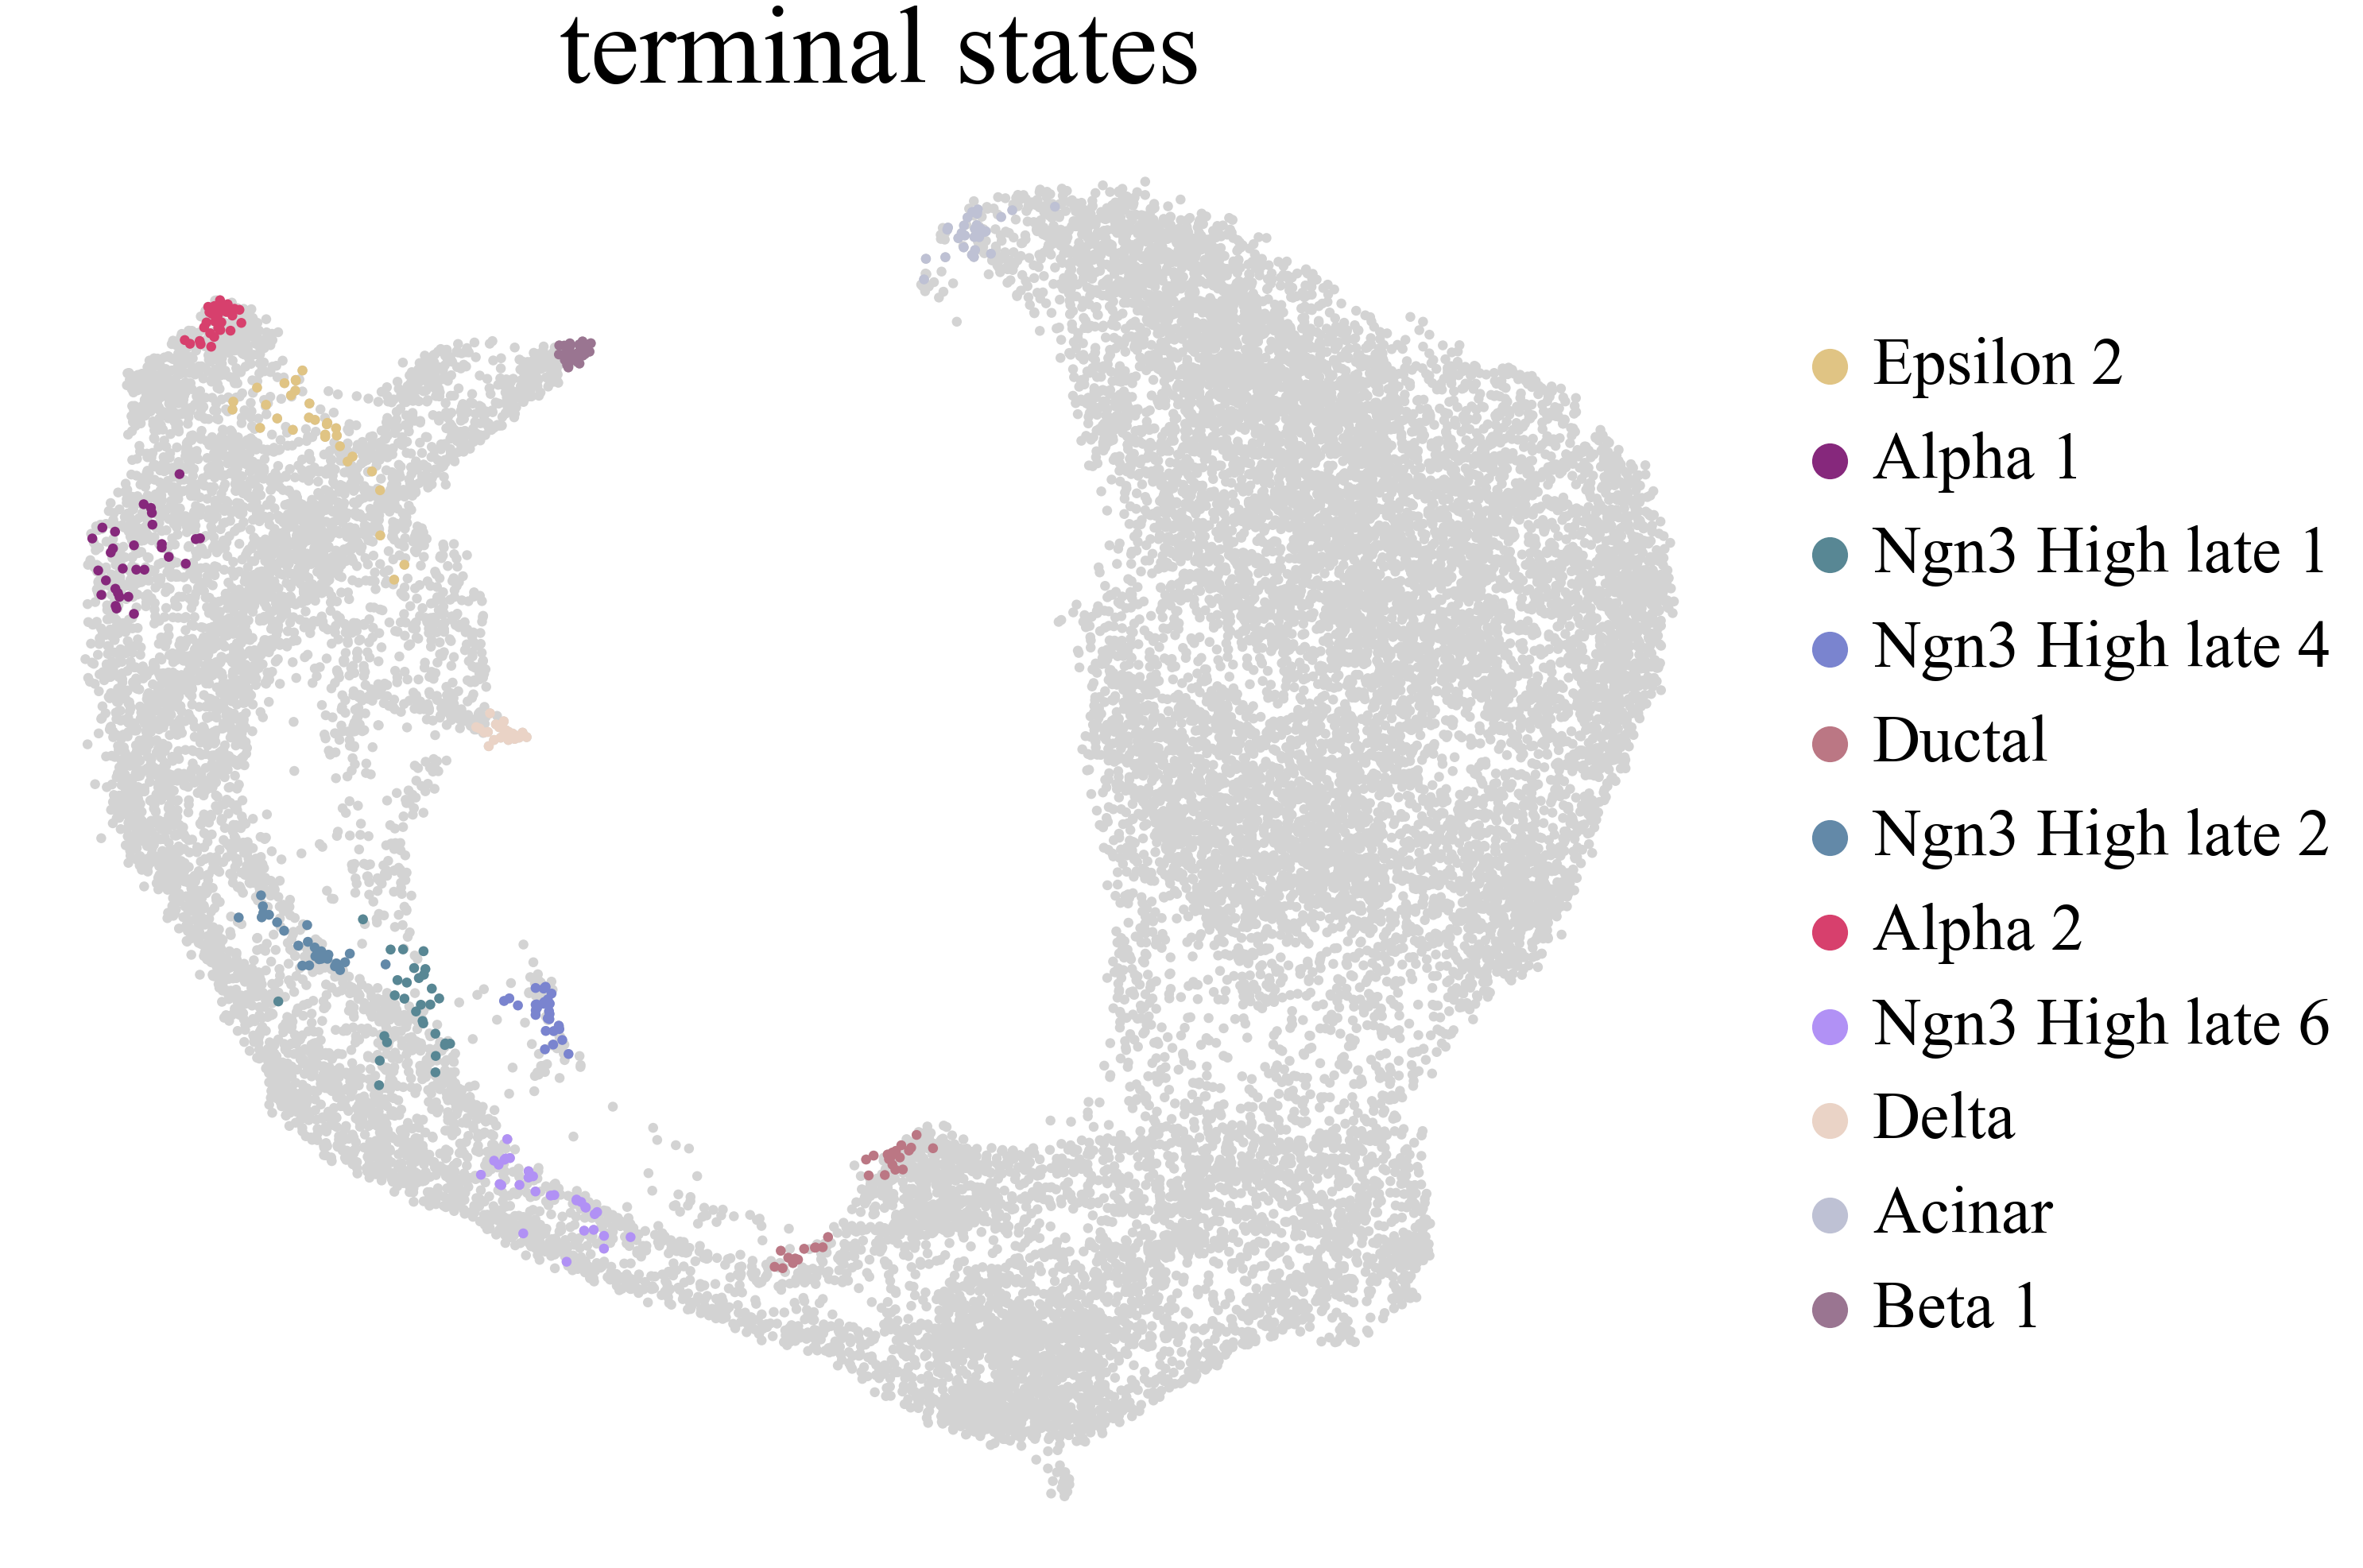

In [33]:
g.compute_terminal_states(method="top_n", n_states=11)
g.plot_terminal_states(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

# Fate Probabilities

  0%|          | 0/9 [00:00<?, ?/s]

[0]PETSC ERROR: 

  0%|          | 0/1 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple MacOS to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


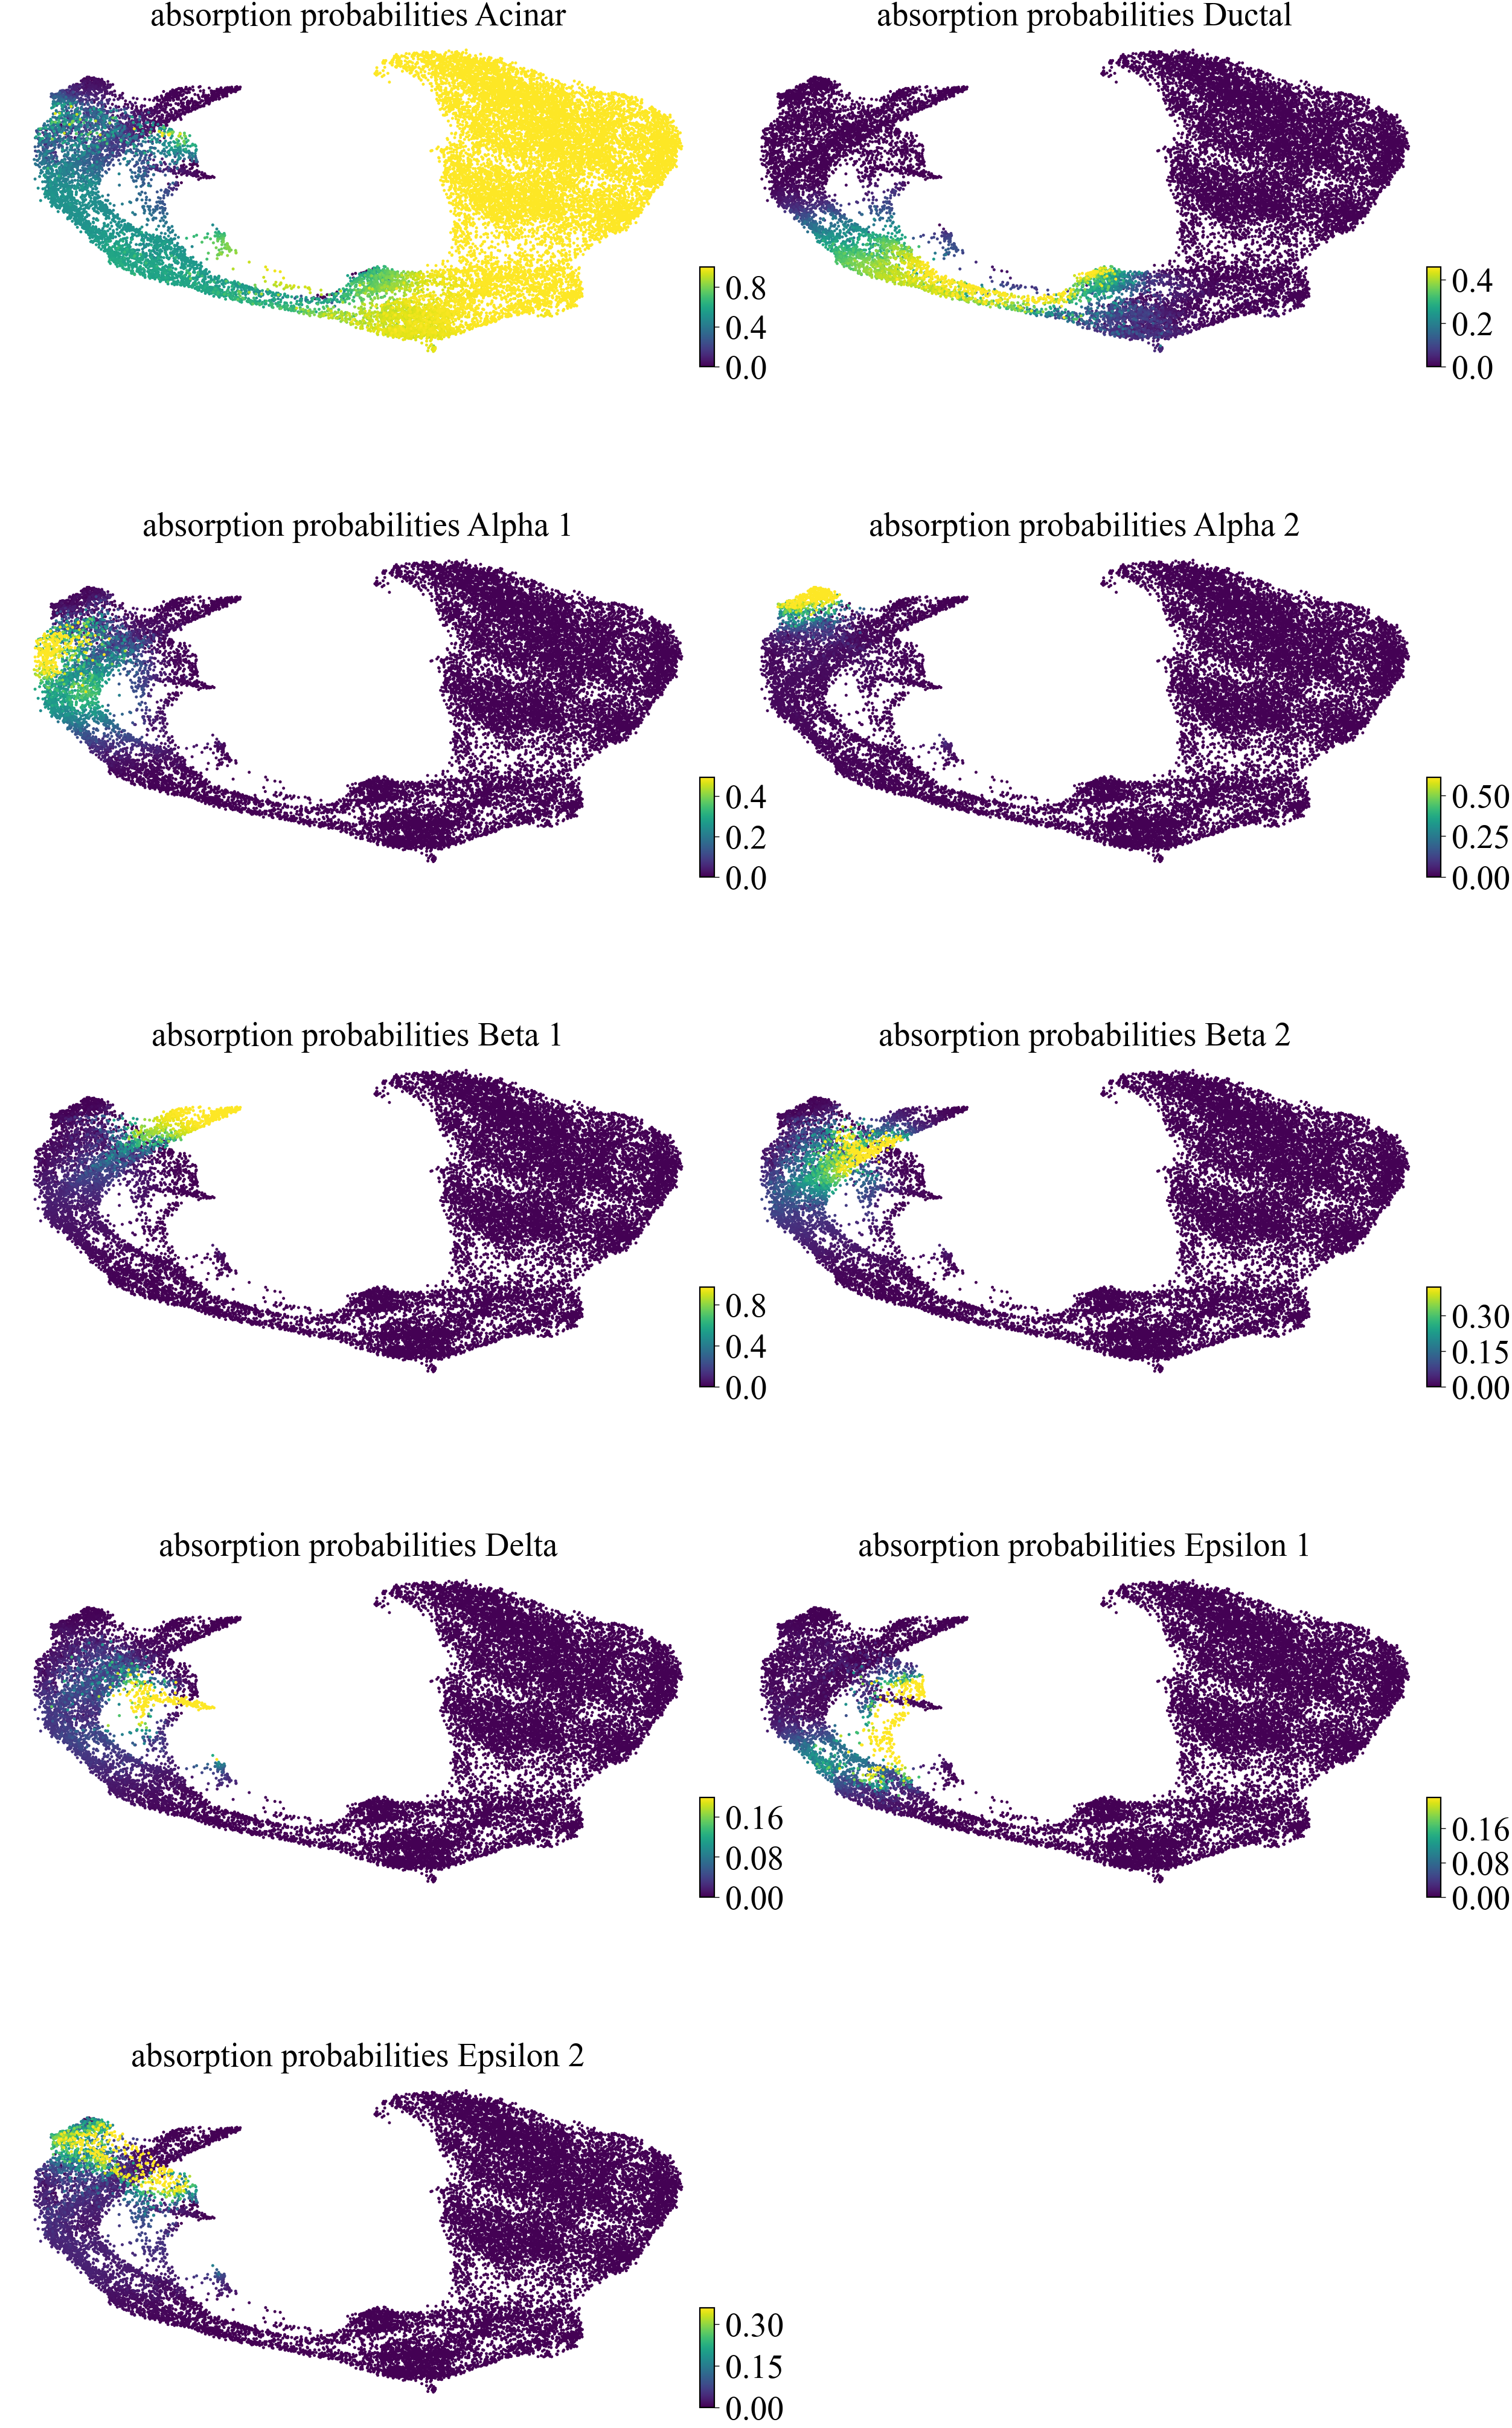

In [23]:
g.set_terminal_states_from_macrostates(
    [
        "Acinar", "Ductal", "Alpha_1", "Alpha_2", "Beta_1", "Beta_2", "Delta", "Epsilon_1", "Epsilon_2"
    ]
)
g.compute_absorption_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu', time_to_absorption='all')
g.plot_absorption_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=2)

# Aggregated Results: EB 0.525 Ngn3: 0.055 NEB: 0.69

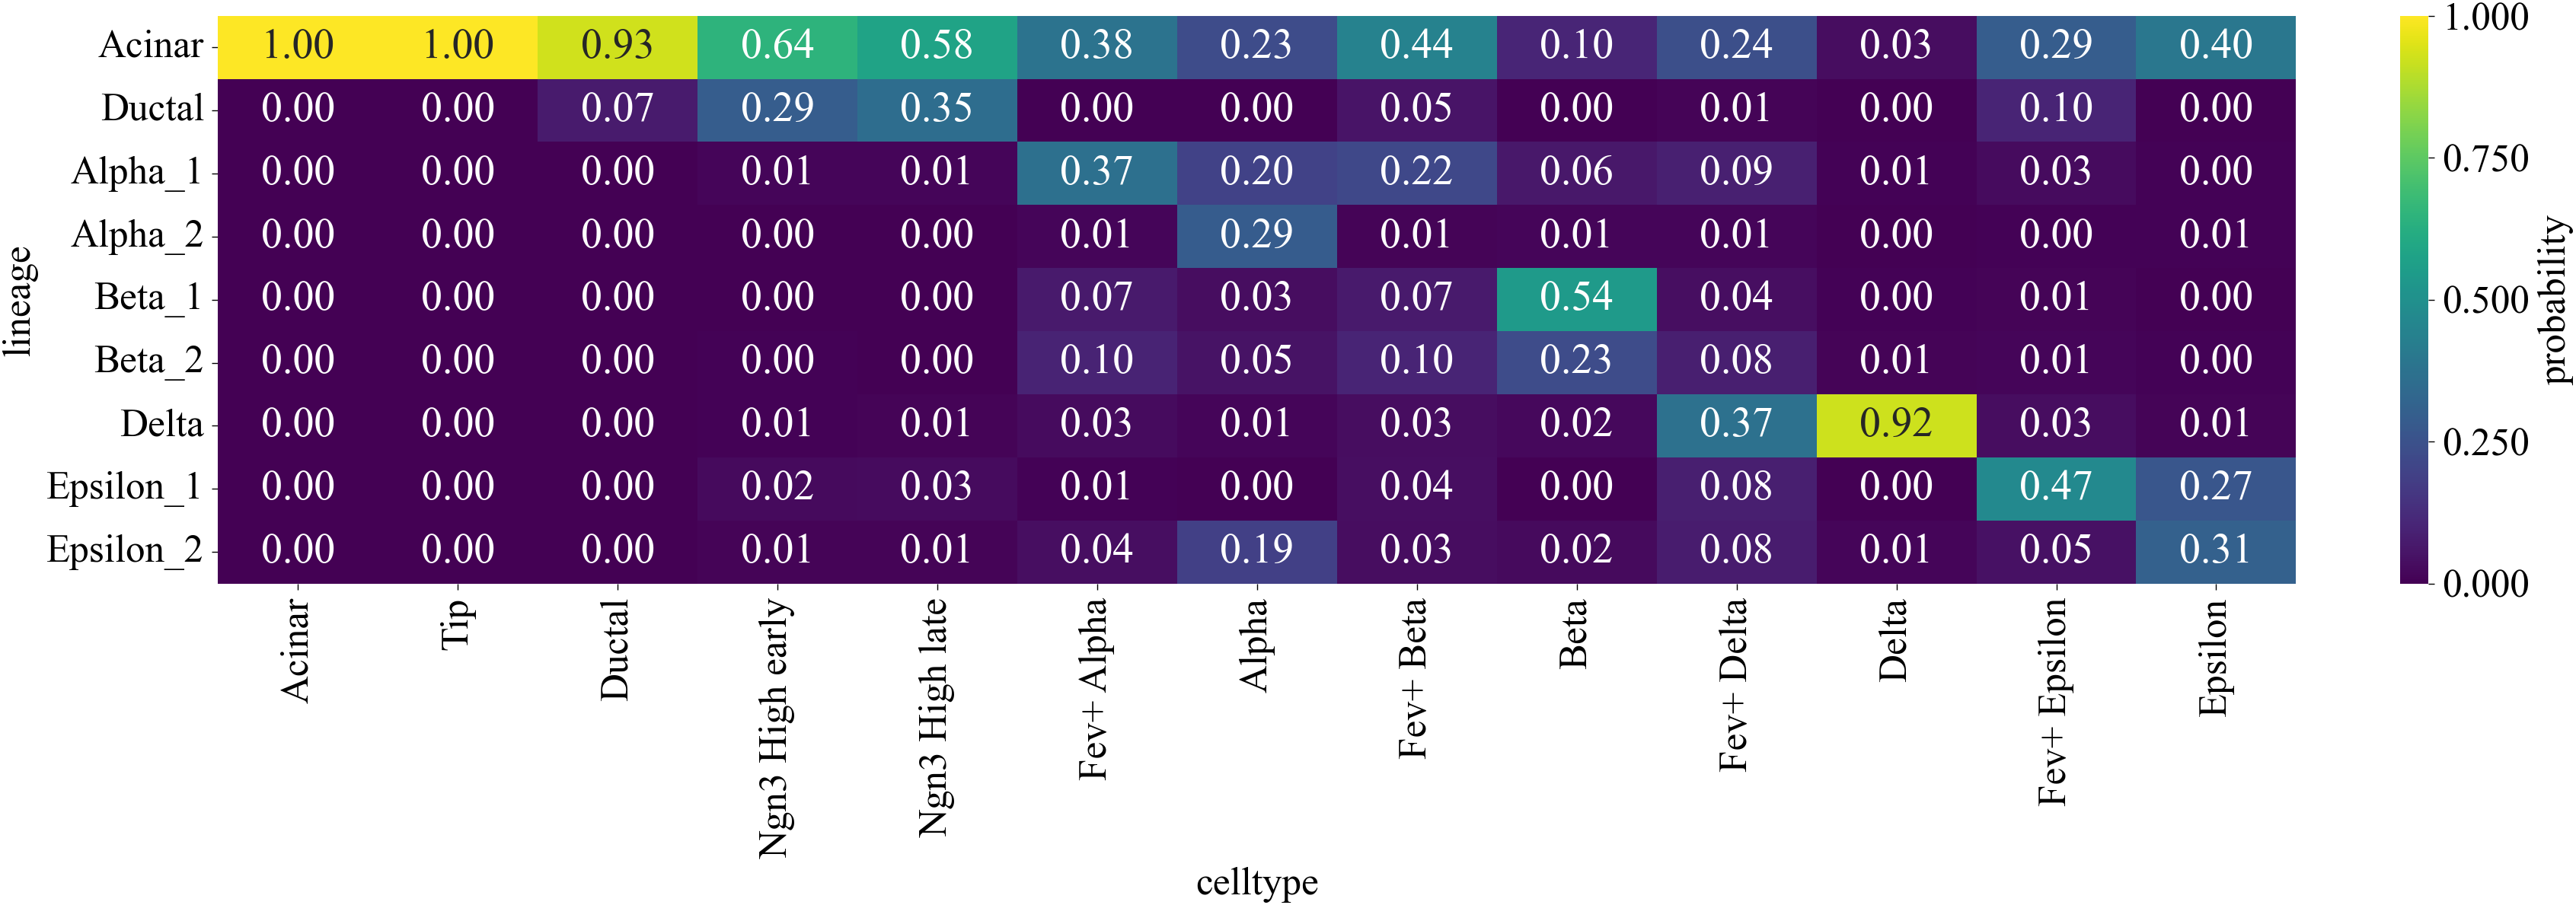

In [24]:
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')

cr.pl.aggregate_absorption_probabilities(
    adata,
    mode='heatmap',
    lineages=["Acinar", "Ductal", "Alpha_1", "Alpha_2", "Beta_1", "Beta_2", "Delta", "Epsilon_1", "Epsilon_2"],
    cluster_key='celltype',
    clusters=['Acinar', 'Tip', 'Ductal', 'Ngn3 High early','Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon'],
    figsize=(17, 6),
    title="",
)